In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Audio config
SR = 22050
WIN_SEC = 1.5
HOP_SEC = 0.75
WIN = int(SR * WIN_SEC)
HOP = int(SR * HOP_SEC)
N_MELS = 64


c:\Python\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [4]:
def extract_logmel(x, sr=SR, n_mels=N_MELS):
    S = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=1024, hop_length=256, n_mels=n_mels)
    log_S = librosa.power_to_db(S, ref=np.max)
    return log_S.astype(np.float32)

def file_to_logmel(path, label):
    x, sr = librosa.load(path, sr=SR, mono=True)
    if np.max(np.abs(x)) > 0:
        x = x / np.max(np.abs(x))
    feats, labels = [], []
    if len(x) < WIN:
        x = np.pad(x, (0, WIN - len(x)))
    for start in range(0, max(len(x) - WIN + 1, 1), HOP):
        seg = x[start:start+WIN]
        feats.append(extract_logmel(seg))
        labels.append(label)
    return np.stack(feats), np.array(labels)


In [5]:
# sireNNet loader
def load_siren_dataset(base_dir):
    X_list, y_list = [], []
    for cls in ["ambulance","firetruck","police"]:
        folder = os.path.join(base_dir, cls)
        for f in os.listdir(folder):
            if f.lower().endswith(".wav"):
                fx, fy = file_to_logmel(os.path.join(folder,f), 1) # siren = 1
                X_list.append(fx); y_list.append(fy)
    # traffic as non-siren
    folder = os.path.join(base_dir, "traffic")
    for f in os.listdir(folder):
        if f.lower().endswith(".wav"):
            fx, fy = file_to_logmel(os.path.join(folder,f), 0)
            X_list.append(fx); y_list.append(fy)
    return np.concatenate(X_list), np.concatenate(y_list)

# UrbanSound8K loader
def load_urbansound(base_dir, metadata_csv):
    df = pd.read_csv(metadata_csv)
    X_list, y_list = [], []
    for _, row in df.iterrows():
        path = os.path.join(base_dir, "fold"+str(row["fold"]), row["slice_file_name"])
        label = 1 if row["class"] == "siren" else 0
        fx, fy = file_to_logmel(path, label)
        X_list.append(fx); y_list.append(fy)
    return np.concatenate(X_list), np.concatenate(y_list)

# ESC-50 loader
def load_esc(base_dir, metadata_csv):
    df = pd.read_csv(metadata_csv)
    X_list, y_list = [], []
    for _, row in df.iterrows():
        path = os.path.join(base_dir, "audio", row["filename"])
        label = 1 if row["category"] == "siren" else 0
        fx, fy = file_to_logmel(path, label)
        X_list.append(fx); y_list.append(fy)
    return np.concatenate(X_list), np.concatenate(y_list)


In [10]:
# import os
# import numpy as np
# import pandas as pd
# import librosa
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from sklearn.model_selection import train_test_split

# # --- Config ---
# SR = 22050
# WIN_SEC = 1.5
# HOP_SEC = 0.75
# WIN = int(SR * WIN_SEC)
# HOP = int(SR * HOP_SEC)
# N_MELS = 64

# # --- Feature extraction helpers ---
# def extract_logmel(x, sr=SR, n_mels=N_MELS):
#     S = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=1024, hop_length=256, n_mels=n_mels)
#     log_S = librosa.power_to_db(S, ref=np.max)
#     return log_S.astype(np.float32)

# def file_to_logmel(path, label):
#     x, sr = librosa.load(path, sr=SR, mono=True)
#     if np.max(np.abs(x)) > 0:
#         x = x / np.max(np.abs(x))
#     feats, labels = [], []
#     if len(x) < WIN:
#         x = np.pad(x, (0, WIN - len(x)))
#     for start in range(0, max(len(x) - WIN + 1, 1), HOP):
#         seg = x[start:start+WIN]
#         feats.append(extract_logmel(seg))
#         labels.append(label)
#     return np.stack(feats), np.array(labels)

# # --- Dataset loaders ---
# def load_siren_dataset(base_dir):
#     X_list, y_list = [], []
#     for cls in ["ambulance","firetruck","police"]:
#         folder = os.path.join(base_dir, cls)
#         for f in os.listdir(folder):
#             if f.lower().endswith(".wav"):
#                 fx, fy = file_to_logmel(os.path.join(folder,f), 1) # siren = 1
#                 X_list.append(fx); y_list.append(fy)
#     # traffic as non-siren
#     folder = os.path.join(base_dir, "traffic")
#     for f in os.listdir(folder):
#         if f.lower().endswith(".wav"):
#             fx, fy = file_to_logmel(os.path.join(folder,f), 0)
#             X_list.append(fx); y_list.append(fy)
#     return np.concatenate(X_list), np.concatenate(y_list)

# def load_urbansound(base_dir, metadata_csv):
#     df = pd.read_csv(metadata_csv)
#     X_list, y_list = [], []
#     for _, row in df.iterrows():
#         path = os.path.join(base_dir, "audio", "fold"+str(row["fold"]), row["slice_file_name"])
#         label = 1 if row["class"] == "siren" else 0
#         try:
#             fx, fy = file_to_logmel(path, label)
#             X_list.append(fx); y_list.append(fy)
#         except Exception as e:
#             print("Skipping file:", path, "Error:", e)
#     return np.concatenate(X_list), np.concatenate(y_list)

# def load_esc(base_dir, metadata_csv):
#     df = pd.read_csv(metadata_csv)
#     X_list, y_list = [], []
#     for _, row in df.iterrows():
#         path = os.path.join(base_dir, "audio", row["filename"])
#         label = 1 if row["category"] == "siren" else 0
#         try:
#             fx, fy = file_to_logmel(path, label)
#             X_list.append(fx); y_list.append(fy)
#         except Exception as e:
#             print("Skipping file:", path, "Error:", e)
#     return np.concatenate(X_list), np.concatenate(y_list)

# --- Load datasets with absolute paths ---
# --- Load datasets with absolute paths ---

# UrbanSound8K (fix: include "audio" in path)
# --- Load datasets with absolute paths ---

# UrbanSound8K → loader will add "audio/foldX/..."
X_us, y_us = load_urbansound(
    r"C:\Users\prate\Downloads\College Academics\Minor Project\Minor Project\datasets\UrbanSound8k\UrbanSound8K\audio",
    r"C:\Users\prate\Downloads\College Academics\Minor Project\Minor Project\datasets\UrbanSound8k\UrbanSound8K\metadata\UrbanSound8K.csv"
)

# ESC-50 → loader will add "audio/filename"
X_esc, y_esc = load_esc(
    r"C:\Users\prate\Downloads\College Academics\Minor Project\Minor Project\datasets\ESC-50\ESC-50-master",
    r"C:\Users\prate\Downloads\College Academics\Minor Project\Minor Project\datasets\ESC-50\ESC-50-master\meta\esc50.csv"
)

# sireNNet → direct folder structure already matches
X_sirenNet, y_sirenNet = load_siren_dataset(
    r"C:\Users\prate\Downloads\College Academics\Minor Project\Minor Project\datasets\sireNNet"
)

# --- Merge all datasets ---
X_all = np.concatenate([X_us, X_esc, X_sirenNet], axis=0)[..., np.newaxis]
y_all = np.concatenate([y_us, y_esc, y_sirenNet], axis=0)

print("✅ Final dataset prepared")
print("Features shape:", X_all.shape)
print("Labels shape:", y_all.shape)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, stratify=y_all, test_size=0.2, random_state=42
)

print("Train set shape:", X_train.shape, "Test set shape:", X_test.shape)




✅ Final dataset prepared
Features shape: (46242, 64, 130, 1)
Labels shape: (46242,)
Train set shape: (36993, 64, 130, 1) Test set shape: (9249, 64, 130, 1)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Optimized CNN model ---
model_siren = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile
model_siren.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_siren.summary()

# --- Callbacks ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,              # stop if no improvement for 10 epochs
    restore_best_weights=True # roll back to best weights
)

checkpoint = ModelCheckpoint(
    "best_siren_model.h5",    # file to save the best model
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# --- Train ---
history = model_siren.fit(
    X_train, y_train,
    epochs=130,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint]
)

# --- Evaluate ---
test_loss, test_acc = model_siren.evaluate(X_test, y_test)
print("✅ Unified Siren Model Test accuracy:", test_acc)


c:\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 130, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 130, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 65, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 65, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 65, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 16, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 16, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 16, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,433 (415.75 KB)

 Trainable params: 105,953 (413.88 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9039 - loss: 0.2410
Epoch 1: val_loss improved from None to 0.15291, saving model to best_siren_model.h5



Epoch 1: finished saving model to best_siren_model.h5
925/925 ━━━━━━━━━━━━━━━━━━━━ 125s 131ms/step - accuracy: 0.9412 - loss: 0.1665 - val_accuracy: 0.9568 - val_loss: 0.1529
Epoch 2/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9687 - loss: 0.0929
Epoch 2: val_loss improved from 0.15291 to 0.07898, saving model to best_siren_model.h5



Epoch 2: finished saving model to best_siren_model.h5
925/925 ━━━━━━━━━━━━━━━━━━━━ 119s 129ms/step - accuracy: 0.9714 - loss: 0.0852 - val_accuracy: 0.9742 - val_loss: 0.0790
Epoch 3/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9777 - loss: 0.0660
Epoch 3: val_loss improved from 0.07898 to 0.06814, saving model to best_siren_model.h5



Epoch 3: finished saving model to best_siren_model.h5
925/925 ━━━━━━━━━━━━━━━━━━━━ 121s 131ms/step - accuracy: 0.9796 - loss: 0.0621 - val_accuracy: 0.9750 - val_loss: 0.0681
Epoch 4/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9818 - loss: 0.0545
Epoch 4: val_loss did not improve from 0.06814
925/925 ━━━━━━━━━━━━━━━━━━━━ 116s 125ms/step - accuracy: 0.9828 - loss: 0.0515 - val_accuracy: 0.9646 - val_loss: 0.1169
Epoch 5/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9860 - loss: 0.0436
Epoch 5: val_loss did not improve from 0.06814
925/925 ━━━━━━━━━━━━━━━━━━━━ 116s 125ms/step - accuracy: 0.9862 - loss: 0.0432 - val_accuracy: 0.9711 - val_loss: 0.0771
Epoch 6/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9885 - loss: 0.0364
Epoch 6: val_loss did not improve from 0.06814
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 125ms/step - accuracy: 0.9885 - loss: 0.0359 - val_accuracy: 0.9523 - val_loss: 0.1586
Epoch 7/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/ste


Epoch 8: finished saving model to best_siren_model.h5
925/925 ━━━━━━━━━━━━━━━━━━━━ 116s 126ms/step - accuracy: 0.9914 - loss: 0.0259 - val_accuracy: 0.9874 - val_loss: 0.0387
Epoch 9/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9927 - loss: 0.0225
Epoch 9: val_loss did not improve from 0.03872
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 125ms/step - accuracy: 0.9921 - loss: 0.0236 - val_accuracy: 0.9738 - val_loss: 0.1057
Epoch 10/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9935 - loss: 0.0188
Epoch 10: val_loss did not improve from 0.03872
925/925 ━━━━━━━━━━━━━━━━━━━━ 114s 123ms/step - accuracy: 0.9931 - loss: 0.0201 - val_accuracy: 0.9811 - val_loss: 0.0602
Epoch 11/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9939 - loss: 0.0196
Epoch 11: val_loss did not improve from 0.03872
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 125ms/step - accuracy: 0.9937 - loss: 0.0203 - val_accuracy: 0.9761 - val_loss: 0.0990
Epoch 12/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 118m


Epoch 13: finished saving model to best_siren_model.h5
925/925 ━━━━━━━━━━━━━━━━━━━━ 122s 132ms/step - accuracy: 0.9943 - loss: 0.0182 - val_accuracy: 0.9909 - val_loss: 0.0339
Epoch 14/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9957 - loss: 0.0146
Epoch 14: val_loss improved from 0.03393 to 0.02265, saving model to best_siren_model.h5



Epoch 14: finished saving model to best_siren_model.h5
925/925 ━━━━━━━━━━━━━━━━━━━━ 119s 129ms/step - accuracy: 0.9948 - loss: 0.0161 - val_accuracy: 0.9935 - val_loss: 0.0227
Epoch 15/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9961 - loss: 0.0104
Epoch 15: val_loss did not improve from 0.02265
925/925 ━━━━━━━━━━━━━━━━━━━━ 122s 131ms/step - accuracy: 0.9957 - loss: 0.0132 - val_accuracy: 0.9788 - val_loss: 0.0909
Epoch 16/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9964 - loss: 0.0118
Epoch 16: val_loss did not improve from 0.02265
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 125ms/step - accuracy: 0.9958 - loss: 0.0139 - val_accuracy: 0.9795 - val_loss: 0.0771
Epoch 17/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9963 - loss: 0.0133
Epoch 17: val_loss did not improve from 0.02265
925/925 ━━━━━━━━━━━━━━━━━━━━ 116s 125ms/step - accuracy: 0.9958 - loss: 0.0147 - val_accuracy: 0.9904 - val_loss: 0.0304
Epoch 18/130
925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 1

290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step


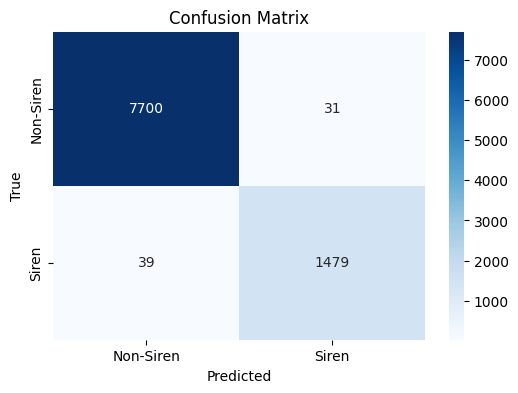

              precision    recall  f1-score   support

   Non-Siren       0.99      1.00      1.00      7731
       Siren       0.98      0.97      0.98      1518

    accuracy                           0.99      9249
   macro avg       0.99      0.99      0.99      9249
weighted avg       0.99      0.99      0.99      9249



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = (model_siren.predict(X_test) > 0.215).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Siren","Siren"], yticklabels=["Non-Siren","Siren"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=["Non-Siren","Siren"]))


In [65]:
import numpy as np
import random

# Pick a random index where the true label is Siren (1)
siren_indices = np.where(y_test == 1)[0]
rand_idx = random.choice(siren_indices)

# Extract the sample
x_sample = X_test[rand_idx:rand_idx+1]   # keep batch dimension
y_true = y_test[rand_idx]

# Predict probability
y_prob = model_siren.predict(x_sample).ravel()[0]

# Apply tuned threshold
THRESH = 0.215
y_pred = int(y_prob > THRESH)

print("🎵 Random Siren Test")
print(f"True Label: {y_true} (1 = Siren)")
print(f"Predicted Probability: {y_prob:.4f}")
print(f"Predicted Label: {y_pred} (Threshold={THRESH})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
🎵 Random Siren Test
True Label: 1 (1 = Siren)
Predicted Probability: 1.0000
Predicted Label: 1 (Threshold=0.215)


In [78]:
import numpy as np
import random

# Pick a random index where the true label is Non-Siren (0)
nonsiren_indices = np.where(y_test == 0)[0]
rand_idx = random.choice(nonsiren_indices)

# Extract the sample
x_sample = X_test[rand_idx:rand_idx+1]   # keep batch dimension
y_true = y_test[rand_idx]

# Predict probability
y_prob = model_siren.predict(x_sample).ravel()[0]

# Apply tuned threshold
THRESH = 0.215
y_pred = int(y_prob > THRESH)

print("🎵 Random Non-Siren Test")
print(f"True Label: {y_true} (0 = Non-Siren)")
print(f"Predicted Probability: {y_prob:.4f}")
print(f"Predicted Label: {y_pred} (Threshold={THRESH})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
🎵 Random Non-Siren Test
True Label: 0 (0 = Non-Siren)
Predicted Probability: 0.0000
Predicted Label: 0 (Threshold=0.215)


In [14]:
from sklearn.metrics import precision_recall_curve

y_prob = model_siren.predict(X_test).ravel()
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"🔍 Best threshold: {best_thresh:.3f}")
print(f"Precision: {precision[best_idx]:.3f}, Recall: {recall[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")


290/290 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step
🔍 Best threshold: 0.292
Precision: 0.983, Recall: 0.972, F1: 0.978


In [79]:
from sklearn.metrics import confusion_matrix

# Predictions with tuned threshold
THRESH = 0.215
y_prob = model_siren.predict(X_test).ravel()
y_pred = (y_prob > THRESH).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# cm layout:
# [[TN, FP],
#  [FN, TP]]
TN, FP, FN, TP = cm.ravel()

# Accuracy formula
accuracy = (TP + TN) / (TP + TN + FP + FN)

print("Confusion Matrix:\n", cm)
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
print(f"Calculated Accuracy: {accuracy:.4f}")


290/290 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step
Confusion Matrix:
 [[7700   31]
 [  39 1479]]
TP: 1479, TN: 7700, FP: 31, FN: 39
Calculated Accuracy: 0.9924


In [ ]:
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model("best_siren_model.h5")

# 1. Save as HDF5 (.h5)
model.save("siren_model.h5")

# 2. Save as native Keras format (.keras)
model.save("siren_model.keras")

# 3. Export as TensorFlow SavedModel (directory format)
model.export("siren_savedmodel")

# 4. Convert to TensorFlow Lite (.tflite)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("siren_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model exported in .h5, .keras, SavedModel, and .tflite formats")


# # 4. Convert to ONNX (.onnx)
# spec = (tf.TensorSpec(model.inputs[0].shape, tf.float32, name="input"),)
# onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
# onnx.save(onnx_model, "siren_model.onnx")

# print("✅ Model exported in all formats: .h5, SavedModel, .tflite, .onnx")



INFO:tensorflow:Assets written to: siren_savedmodel\assets


INFO:tensorflow:Assets written to: siren_savedmodel\assets


Saved artifact at 'siren_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 130, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2636689481104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689482064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689481680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689481488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689480912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689481872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689482256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689483216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689482832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689482640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689480720: TensorSpec(shape=(), 

INFO:tensorflow:Assets written to: C:\Users\prate\AppData\Local\Temp\tmpijxktgvx\assets


Saved artifact at 'C:\Users\prate\AppData\Local\Temp\tmpijxktgvx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 130, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2636689481104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689482064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689481680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689481488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689480912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689481872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689482256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689483216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689482832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689482640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2636689

: 